<a href="https://colab.research.google.com/github/Berchie-Sam/Glaucoma_Detection/blob/main/%5Bglaucoma%5DNewExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Input, Conv2D, Lambda, Reshape, AveragePooling2D, Dense, ReLU, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from os import listdir
from matplotlib import image
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
import joblib
import math
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
!pip install visualkeras
import visualkeras
from tensorflow.keras.preprocessing import image
%matplotlib inline
from sklearn.model_selection import KFold
from keras import initializers
from google.colab import drive
from tensorflow.keras.models import load_model
import seaborn as sns
from PIL import Image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 9.2 MB/s eta 0:00:00


In [ ]:

# Check if the TPU system has already been initialized
if 'COLAB_TPU_ADDR' in os.environ:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
else:
    strategy = tf.distribute.OneDeviceStrategy('GPU:0')  # Use GPU if TPU is not available


In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Projects/Final(Undergraduate)/[augmented]RIMONE-DL_dataset'

In [ ]:
with strategy.scope():
    batch_size = 48
    Image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
    )


Found 618 images belonging to 2 classes.
Number of batches:  13
Images per batch:  48
Number of classes:  2
**Number of images per class**
Class 'Glaucoma': 309 images
Class 'Normal': 309 images
Total number of images: 618


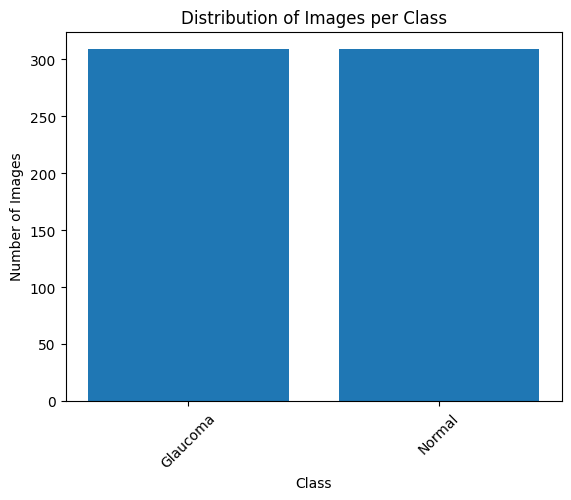

In [ ]:
from collections import Counter

with strategy.scope():
    generator = ImageDataGenerator(rescale=1./255)
    train_generator = generator.flow_from_directory(
          data_dir,
          target_size=(256, 256),
          batch_size=batch_size,
          class_mode='categorical'
    )

    num_batches = len(train_generator)
    print('Number of batches: ', num_batches)

    images_per_batch = train_generator.batch_size
    print('Images per batch: ', images_per_batch)

    num_classes = train_generator.num_classes
    print("Number of classes: ", num_classes)

    # Count the number of images in each class
    class_indices = train_generator.classes
    image_counts_per_class = dict(Counter(class_indices))

    print("**Number of images per class**")
    total_images = 0
    for class_index in range(num_classes):
        class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(class_index)]
        class_count = image_counts_per_class[class_index]
        total_images += class_count
        print(f"Class '{class_name}': {class_count} images")

    print('Total number of images:', total_images)

    # Plot the distribution of images per class
    plt.bar(image_counts_per_class.keys(), image_counts_per_class.values())
    plt.xticks(range(num_classes), [list(train_generator.class_indices.keys())[i] for i in range(num_classes)], rotation=45)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Images per Class')
    plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

with strategy.scope():
  # Initialize empty lists to store data splits
  X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

  # Loop through batches from the generator
  for _ in range(num_batches):
      X_batch, y_batch = train_generator.next()

      # Split each batch into train, validation, and test
      X_batch_train, X_batch_temp, y_batch_train, y_batch_temp = train_test_split(X_batch, y_batch, test_size=0.4, random_state=42)
      X_batch_val, X_batch_test, y_batch_val, y_batch_test = train_test_split(X_batch_temp, y_batch_temp, test_size=0.5, random_state=42)

      # Append the splits to the lists
      X_train.append(X_batch_train)
      y_train.append(y_batch_train)
      X_val.append(X_batch_val)
      y_val.append(y_batch_val)
      X_test.append(X_batch_test)
      y_test.append(y_batch_test)

  # Concatenate the splits to get the final train, validation, and test sets
  X_train = np.concatenate(X_train)
  y_train = np.concatenate(y_train)
  X_val = np.concatenate(X_val)
  y_val = np.concatenate(y_val)
  X_test = np.concatenate(X_test)
  y_test = np.concatenate(y_test)


CNN

In [ ]:
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name = 'Block1_Conv1', input_shape=input_shape))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name = 'Block1_Conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'Block1_Pool'))
    #model.add(Dropout(0.25, name = 'Block1_Dropout'))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', name = 'Block2_Conv1'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', name = 'Block2_Conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'Block2_Pool'))
    #model.add(Dropout(0.25, name = 'Block2_Dropout'))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', name = 'Block3_Conv1'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', name = 'Block3_Conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'Block3_Pool'))
    #model.add(Dropout(0.25, name = 'Block3_Dropout'))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', name = 'Block4_Conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'Block4_Pool'))
    model.add(Dropout(0.25, name = 'Block4_Dropout'))

    model.add(Flatten(name = 'Flatten'))
    model.add(Dropout(0.5, name = 'Dropout'))
    model.add(Dense(units=num_classes, activation='sigmoid', name = 'Output'))
    return model


In [ ]:
with strategy.scope():
  # Defines the input shape
  input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
  cnn_model = create_cnn_model(input_shape)

In [ ]:

with strategy.scope():
  # Compile the model
  cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

  # Model summary
  cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Block1_Conv1 (Conv2D)       (None, 254, 254, 64)      1792      
                                                                 
 Block1_Conv2 (Conv2D)       (None, 252, 252, 64)      36928     
                                                                 
 Block1_Pool (MaxPooling2D)  (None, 126, 126, 64)      0         
                                                                 
 Block2_Conv1 (Conv2D)       (None, 124, 124, 128)     73856     
                                                                 
 Block2_Conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 Block2_Pool (MaxPooling2D)  (None, 61, 61, 128)       0         
                                                                 
 Block3_Conv1 (Conv2D)       (None, 59, 59, 256)       2

In [ ]:

with strategy.scope():
  vis = visualkeras.layered_view(cnn_model, scale_xy=1, scale_z=1, max_z=100, legend = True)
  vis.show()

In [ ]:
with strategy.scope():
  # Define the directory to save the model checkpoints
  checkpoint_dir = '/content/drive/MyDrive/Model_Checkpoints/Projects/Glaucoma_Detection'

  # Ensure the directory exists
  os.makedirs(checkpoint_dir, exist_ok=True)

  epochs = 50

In [ ]:

class ValidationAccuracyStopCallback(Callback):
    def __init__(self, target_accuracy):
        super(ValidationAccuracyStopCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= self.target_accuracy:
            print(f"Stopping training as val_accuracy reached {self.target_accuracy}%.")
            self.model.stop_training = True

In [ ]:

class AccuracyStopCallback(Callback):
    def __init__(self, target_accuracy):
        super(AccuracyStopCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_accuracy:
            print(f"Stopping training as accuracy reached {self.target_accuracy}%.")
            self.model.stop_training = True

In [ ]:
with strategy.scope():
  # Define the custom validation accuracy stopping callback
    target_accuracy = 1.0
    val_accuracy_stop = ValidationAccuracyStopCallback(target_accuracy)

In [ ]:
with strategy.scope():
  # Define the custom validation accuracy stopping callback
    target_accuracy = 1.0
    accuracy_stop = AccuracyStopCallback(target_accuracy)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with strategy.scope():
  # Define the EarlyStopping callback
  early_stop = EarlyStopping(monitor='accuracy', patience=10, verbose=1, mode='max')

  # Create ModelCheckpoint callback for CNN model
  cnn_checkpoint_path = os.path.join(checkpoint_dir, 'cnn_model_checkpoint.h5')
  cnn_model_checkpoint = ModelCheckpoint(cnn_checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

  # Train the model on the training set
  CNN_history = cnn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stop, val_accuracy_stop, accuracy_stop, cnn_model_checkpoint])#


Epoch 1/50
6/8 [=====================>........] - ETA: 1s - loss: 0.6966 - accuracy: 0.4896

8/8 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.4958
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to /content/drive/MyDrive/Model_Checkpoints/Projects/Glaucoma_Detection/cnn_model_checkpoint.h5
8/8 [==============================] - 52s 3s/step - loss: 0.6961 - accuracy: 0.4958 - val_loss: 0.6902 - val_accuracy: 0.5625
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.5014
Epoch 2: val_accuracy did not improve from 0.56250
8/8 [==============================] - 6s 740ms/step - loss: 0.6946 - accuracy: 0.5014 - val_loss: 0.6913 - val_accuracy: 0.5625
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.4875
Epoch 3: val_accuracy did not improve from 0.56250
8/8 [==============================] - 6s 707ms/step - loss: 0.6878 - accuracy: 0.4875 - val_loss: 0.7623 - val_accuracy: 0.4375
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0

CAPSULE NETWORK

In [ ]:

def squash(x, axis=-1, keepdims=True):
    squared_norm = tf.reduce_sum(tf.square(x), axis=axis, keepdims=keepdims)
    scale = squared_norm / (1 + squared_norm) / tf.sqrt(squared_norm + tf.keras.backend.epsilon())
    return scale * x


In [ ]:
def margin_loss(y_true, y_pred):
    margin = 0.5
    margin_positive = K.square(K.relu(1 - margin - y_pred))
    loss = K.sum(y_true * margin_positive, axis=-1)
    return loss


In [ ]:
class Class_Capsule(layers.Layer):
    """
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    :param share_weights: whether to share weights among capsules
    :param kernel_initializer: initializer for the kernel weights
    :param activation: activation function for the output vectors
    """
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=False,
                 kernel_initializer='glorot_uniform', activation='squash', **kwargs):
        super(Class_Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        self.kernel_initializer = initializers.get(kernel_initializer)
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        assert len(input_shape) >= 3
        input_num_capsule = input_shape[1]
        input_dim_capsule = input_shape[2]
        if self.share_weights:
            self.kernel = self.add_weight(name='capsule_kernel',
                                          shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                          initializer=self.kernel_initializer,
                                          trainable=True)
        else:
            self.kernel = self.add_weight(name='capsule_kernel',
                                          shape=(input_num_capsule, input_dim_capsule,
                                                 self.num_capsule * self.dim_capsule),
                                          initializer=self.kernel_initializer,
                                          trainable=True)

    def call(self, inputs, training=None):
        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])


        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, self.num_capsule, input_num_capsule, self.dim_capsule))

        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, 0, :])

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        for i in range(self.routings):
            # # # Simplified routing # # #
            norm_hat_inputs = tf.norm(hat_inputs, axis=-1)
            weighted_hat_inputs = hat_inputs * tf.expand_dims(norm_hat_inputs, axis=-1)
            o = K.sum(weighted_hat_inputs, axis=2) / self.dim_capsule
            o = self.activation(o)

        # End: Routing algorithm -----------------------------------------------------------------------#
        return o

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(Class_Capsule, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [ ]:
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

In [ ]:

with strategy.scope():
    # Get the output of the third convolutional layer
    cnn_output = cnn_model.layers[11].output
    x = Conv2D(filters=128, kernel_size=(7, 7), activation='relu', name='Block5_Conv1')(cnn_output)
    x = Conv2D(filters=128, kernel_size=(6, 6), activation='relu', name='Block5_Conv2')(x)

    # Primary Capsule
    x = PrimaryCap(x, dim_capsule=16, n_channels=2, kernel_size=2, strides=2, padding='valid')

    # Class Capsule Layer
    capsule = Class_Capsule(num_classes, 16, 4, kernel_initializer='glorot_uniform')(x)

    Caps_output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), axis=2)))(capsule)

    #Output = Flatten(name='Output')(Caps_output)  # 14

    #Final_output = Dense(units=2, activation='softmax', name='OutputLayer')(Caps_output)

    CapsNet_model = Model(inputs=cnn_model.input, outputs=Caps_output)

    # Using margin loss
    optimizer = Adam(learning_rate=1e-4) #(0.0001)
    CapsNet_model.compile(loss=margin_loss, optimizer=optimizer, metrics='accuracy')
    CapsNet_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Block1_Conv1_input (InputLa  [(None, 256, 256, 3)]    0         
 yer)                                                            
                                                                 
 Block1_Conv1 (Conv2D)       (None, 254, 254, 64)      1792      
                                                                 
 Block1_Conv2 (Conv2D)       (None, 252, 252, 64)      36928     
                                                                 
 Block1_Pool (MaxPooling2D)  (None, 126, 126, 64)      0         
                                                                 
 Block2_Conv1 (Conv2D)       (None, 124, 124, 128)     73856     
                                                                 
 Block2_Conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                             

In [ ]:
with strategy.scope():
  # Create ModelCheckpoint callback for CapsNet model
  CapsNet_checkpoint_path = os.path.join(checkpoint_dir, 'CapsNet_model_checkpoint.h5')
  CapsNet_model_checkpoint = ModelCheckpoint(CapsNet_checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

  # Train the model on the training set
  CapsNet_history = CapsNet_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stop, val_accuracy_stop, accuracy_stop, CapsNet_model_checkpoint]) #


Epoch 1/50
6/8 [=====================>........] - ETA: 1s - loss: 0.2498 - accuracy: 0.5000

8/8 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.5263
Epoch 1: val_accuracy improved from -inf to 0.61719, saving model to /content/drive/MyDrive/Model_Checkpoints/Projects/Glaucoma_Detection/CapsNet_model_checkpoint.h5
8/8 [==============================] - 12s 1s/step - loss: 0.2496 - accuracy: 0.5263 - val_loss: 0.2483 - val_accuracy: 0.6172
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.5069
Epoch 2: val_accuracy did not improve from 0.61719
8/8 [==============================] - 6s 726ms/step - loss: 0.2474 - accuracy: 0.5069 - val_loss: 0.2461 - val_accuracy: 0.5625
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.5014
Epoch 3: val_accuracy did not improve from 0.61719
8/8 [==============================] - 6s 760ms/step - loss: 0.2459 - accuracy: 0.5014 - val_loss: 0.2451 - val_accuracy: 0.5625
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 0.2450 - accurac

Gabor CapsNet

In [ ]:
class GaborLayer(Layer):
    def __init__(self, filters, kernel_size, strides=(1, 1), activation=None, **kwargs):
        super(GaborLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.activation = activation

    def build(self, input_shape):
        input_channels = input_shape[-1]
        self.kernels_real, self.kernels_imag = self._create_gabor_kernels(input_channels)
        self.built = True

    def call(self, inputs):
        # Perform convolution with complex Gabor filters
        conv_real = K.conv2d(inputs, self.kernels_real, strides=self.strides, padding='valid')
        conv_imag = K.conv2d(inputs, self.kernels_imag, strides=self.strides, padding='valid')

        # Combine real and imaginary parts
        output = K.sqrt(K.square(conv_real) + K.square(conv_imag))

        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] = self.filters
        return tuple(output_shape)

    def _create_gabor_kernels(self, input_channels):
        kernels_real = []
        kernels_imag = []

        # Generate Gabor filters
        for _ in range(self.filters):
            kernel_real, kernel_imag = self._generate_gabor_filter(self.kernel_size, input_channels)
            kernels_real.append(kernel_real)
            kernels_imag.append(kernel_imag)

        # Stack filters along the channel dimension
        kernels_real = K.stack(kernels_real, axis=-1)
        kernels_imag = K.stack(kernels_imag, axis=-1)

        return kernels_real, kernels_imag

    def _generate_gabor_filter(self, kernel_size, input_channels):
        # Create Gabor filter parameters
        sigma = 0.56 * ((kernel_size[0] - 1) * 0.5 - 1) + 0.25
        theta = np.random.uniform(0, np.pi)
        lambda_ = np.random.uniform(0.5, kernel_size[0] - 0.5)
        psi = np.random.uniform(0, np.pi)
        gamma = np.random.uniform(0.5, 1)

        # Generate Gabor filter
        x0 = (kernel_size[0] - 1) // 2
        y0 = (kernel_size[1] - 1) // 2

        y, x = np.mgrid[-x0:x0 + 1, -y0:y0 + 1]
        distance_from_center = np.sqrt(x**2 + y**2)
        mask = np.where(distance_from_center <= min(x0, y0), 1.0, 0.0)

        x_theta = x * np.cos(theta) + y * np.sin(theta)
        y_theta = -x * np.sin(theta) + y * np.cos(theta)

        kernel_real = mask * np.exp(-0.5 * (x_theta ** 2 + gamma ** 2 * y_theta ** 2) / sigma ** 2) \
                      * np.cos(2 * np.pi * x_theta / lambda_ + psi)
        kernel_imag = mask * np.exp(-0.5 * (x_theta ** 2 + gamma ** 2 * y_theta ** 2) / sigma ** 2) \
                      * np.sin(2 * np.pi * x_theta / lambda_ + psi)

        # Reshape the kernels to match the input channel dimensions
        kernel_real = kernel_real.reshape((kernel_size[0], kernel_size[1], 1))
        kernel_imag = kernel_imag.reshape((kernel_size[0], kernel_size[1], 1))

        # Repeat the kernels for each input channel
        kernel_real = np.repeat(kernel_real, input_channels, axis=-1)
        kernel_imag = np.repeat(kernel_imag, input_channels, axis=-1)

        # Convert the kernels to tensors
        kernel_real = K.constant(kernel_real, dtype=K.floatx())
        kernel_imag = K.constant(kernel_imag, dtype=K.floatx())

        return kernel_real, kernel_imag

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "strides": self.strides,
            "activation": self.activation,
         })
        return config


In [ ]:
with strategy.scope():
  # Get the output of the third convolutional layer
  cnn_output = cnn_model.layers[11].output
  x = Conv2D(filters=128, kernel_size=(7, 7), activation='relu', name='Block5_Conv1')(cnn_output)
  print('X: ', x.shape)

  gabor_layer = GaborLayer(filters=128, kernel_size=(5, 5), strides=(1, 1), activation=K.relu, name='GaborLayer')(x)

  #Primary Capsule
  x = PrimaryCap(gabor_layer, dim_capsule=16, n_channels=2, kernel_size=2, strides=2, padding='valid')

  # Secondary Capsule Layer
  capsule = Class_Capsule(num_classes, 16, 4, True)(x)
  Caps_output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), axis=2)))(capsule)

  #Output_flattened = Flatten(name='Output')(capsule)

  #Final_output = Dense(units=2, activation='softmax', name='OutputLayer')(Output_flattened)

  # Create the combined model
  GCN_model = Model(inputs=cnn_model.input, outputs=Caps_output)

  # Using margin loss
  optimizer = Adam(learning_rate=1e-4) #(0.0001)

  # Compile the model
  GCN_model.compile(loss=margin_loss, optimizer=optimizer, metrics='accuracy')

  # Model summary
  GCN_model.summary() #


X:  (None, 7, 7, 128)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Block1_Conv1_input (InputLa  [(None, 256, 256, 3)]    0         
 yer)                                                            
                                                                 
 Block1_Conv1 (Conv2D)       (None, 254, 254, 64)      1792      
                                                                 
 Block1_Conv2 (Conv2D)       (None, 252, 252, 64)      36928     
                                                                 
 Block1_Pool (MaxPooling2D)  (None, 126, 126, 64)      0         
                                                                 
 Block2_Conv1 (Conv2D)       (None, 124, 124, 128)     73856     
                                                                 
 Block2_Conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                     

In [ ]:
with strategy.scope():
  # Define the EarlyStopping callback
  early_stop = EarlyStopping(monitor='accuracy', patience=25, verbose=1, mode='max')

  # Create ModelCheckpoint callback for CapsNet model
  GCN_checkpoint_path = os.path.join(checkpoint_dir, 'GCN_model_checkpoint.h5')
  GCN_model_checkpoint = ModelCheckpoint(GCN_checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

  # Train the model on the training set
  GCN_history = GCN_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks= [early_stop, accuracy_stop, val_accuracy_stop, GCN_model_checkpoint]) #


Epoch 1/50
6/8 [=====================>........] - ETA: 1s - loss: 0.2448 - accuracy: 0.5208

8/8 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.5014
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to /content/drive/MyDrive/Model_Checkpoints/Projects/Glaucoma_Detection/GCN_model_checkpoint.h5
8/8 [==============================] - 11s 988ms/step - loss: 0.2446 - accuracy: 0.5014 - val_loss: 0.2420 - val_accuracy: 0.5625
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.5042
Epoch 2: val_accuracy improved from 0.56250 to 0.60938, saving model to /content/drive/MyDrive/Model_Checkpoints/Projects/Glaucoma_Detection/GCN_model_checkpoint.h5
8/8 [==============================] - 6s 754ms/step - loss: 0.2404 - accuracy: 0.5042 - val_loss: 0.2372 - val_accuracy: 0.6094
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.6150
Epoch 3: val_accuracy did not improve from 0.60938
8/8 [==============================] - 6s 774ms/step - loss: 0.2347 - accuracy: 0.6150 - val_loss:

In [ ]:

# Define the function to generate class activation maps using Grad-CAM
def generate_cam(model, img, class_index, layer_name):
    img = np.expand_dims(img, axis=0)
    grad_model = Model(inputs=model.inputs, outputs=(model.get_layer(layer_name).output, model.output))

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img)
        class_output = predictions[:, class_index]

    grads = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0].numpy()

    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


Class index:  0


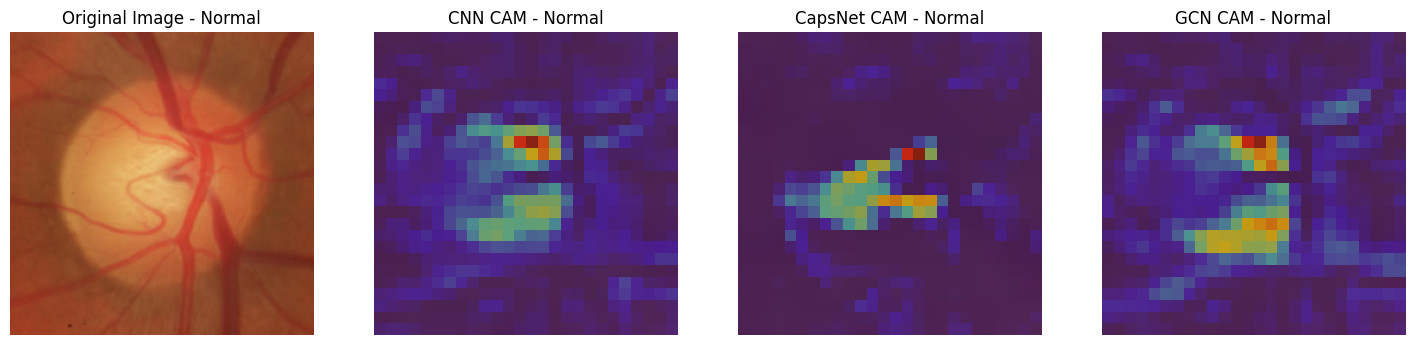

Class index:  1


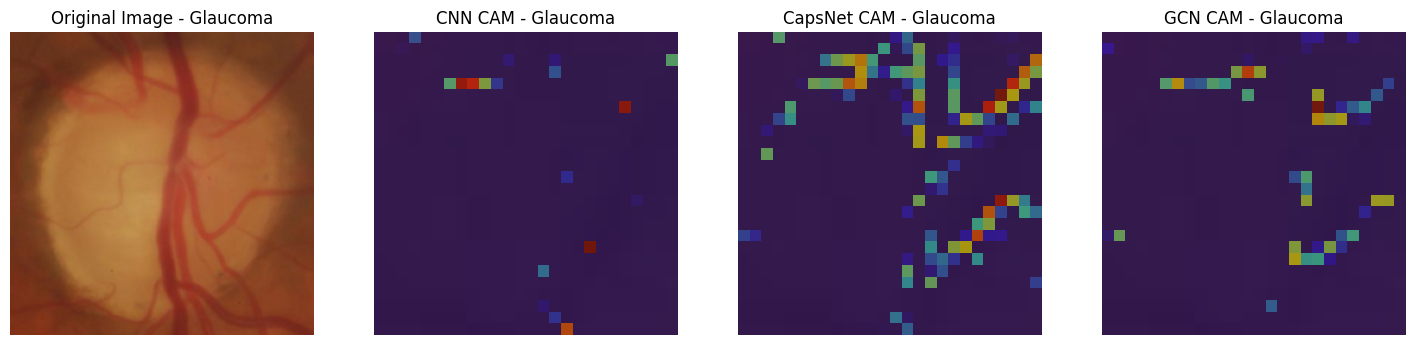

In [ ]:

# Convert data_dir to a string
data_dir = str(data_dir)

# Get image filenames for each class
normal_img = [fn for fn in os.listdir(os.path.join(data_dir, 'Normal')) if fn == 'r1_Im040.png']
glaucoma_img = [fn for fn in os.listdir(os.path.join(data_dir, 'Glaucoma')) if fn == 'r2_Im302.png']

# Combine the image filenames for both classes
image_filenames = normal_img + glaucoma_img

# Get class indices and names
class_indices = {'Normal': 0, 'Glaucoma': 1}
class_names = list(class_indices.keys())

# Generate Grad-CAM for one image from each class
for image_filename in image_filenames:
    # Determine the class based on the image filename
    class_name = 'Glaucoma' if image_filename in glaucoma_img else 'Normal'
    class_index = class_indices[class_name]

    # Find the full image path
    image_path = os.path.join(data_dir, class_name, image_filename)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (X_train.shape[1], X_train.shape[2]))
    img = img / 255.0  # Normalize the image

    print('Class index: ', class_index)

    # Generate CAM for CNN model
    cam_cnn = generate_cam(cnn_model, img, class_index, 'Block4_Conv1')

    # Generate CAM for CapsNet model
    cam_capsnet = generate_cam(CapsNet_model, img, class_index, 'Block4_Conv1')

    # Generate CAM for GCN model
    cam_gcn = generate_cam(GCN_model, img, class_index, 'Block4_Conv1')

   # Ensure the heatmap has non-zero values before normalization
    if np.max(cam_cnn) != 0:
        cam_cnn /= np.max(cam_cnn)
    else:
        cam_cnn = np.zeros_like(cam_cnn)


    if np.max(cam_capsnet) != 0:
        cam_capsnet /= np.max(cam_capsnet)
    else:
      cam_capsnet = np.zeros_like(cam_capsnet)

    if np.max(cam_gcn) != 0:
        cam_gcn /= np.max(cam_gcn)
    else:
      cam_gcn = np.zeros_like(cam_gcn)

    # Plot the original image and overlaid CAMs
    plt.figure(figsize=(18, 4))
    plt.subplot(141)
    plt.imshow(img[:, :, ::-1])
    plt.title(f'Original Image - {class_name}')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(img[:, :, ::-1])
    plt.imshow(cam_cnn, cmap='jet', alpha=0.5)
    plt.title(f'CNN CAM - {class_name}')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(img[:, :, ::-1])
    plt.imshow(cam_capsnet, cmap='jet', alpha=0.5)
    plt.title(f'CapsNet CAM - {class_name}')
    plt.axis('off')

    plt.subplot(144)
    plt.imshow(img[:, :, ::-1])
    plt.imshow(cam_gcn, cmap='jet', alpha=0.5)
    plt.title(f'GCN CAM - {class_name}')
    plt.axis('off')

    plt.show()



#**EVALUATION**



1. Evaluation on Testing set



In [ ]:
# CNN model evaluation
y_pred_cnn = cnn_model.predict(X_test)
y_pred_cnn_binary = (y_pred_cnn > 0.5).astype(int)
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, y_test, verbose=0)
cnn_test_auc_score = roc_auc_score(y_test, y_pred_cnn)

# CapsNet model evaluation
y_pred_capsnet = CapsNet_model.predict(X_test)
y_pred_capsnet_binary = (y_pred_capsnet > 0.5).astype(int)
capsnet_test_loss, capsnet_test_acc = CapsNet_model.evaluate(X_test, y_test, verbose=0)
capsnet_test_auc_score = roc_auc_score(y_test, y_pred_capsnet)

# GCN model evaluation
y_pred_gcn = GCN_model.predict(X_test)
y_pred_gcn_binary = (y_pred_gcn > 0.5).astype(int)
gcn_test_loss, gcn_test_acc = GCN_model.evaluate(X_test, y_test, verbose=0)
gcn_test_auc_score = roc_auc_score(y_test, y_pred_gcn)


5/5 [==============================] - 1s 101ms/step


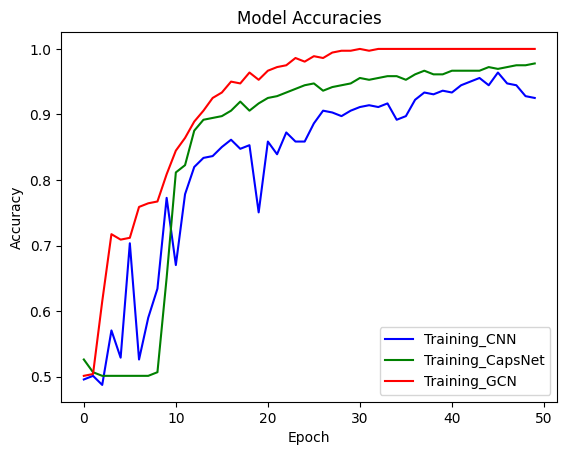

In [ ]:
with strategy.scope():
  # Plotting accuracies
  plt.plot(CNN_history.history['accuracy'], label='Training_CNN', color='blue')
  plt.plot(CapsNet_history.history['accuracy'], label='Training_CapsNet', color='green')
  plt.plot(GCN_history.history['accuracy'], label='Training_GCN', color='red')
  plt.title('Model Accuracies')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()


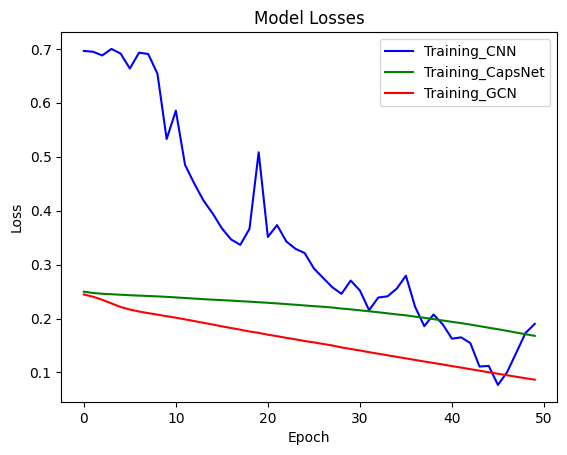

In [ ]:
with strategy.scope():
  # Plotting losses
  plt.plot(CNN_history.history['loss'], label='Training_CNN', color='blue')
  plt.plot(CapsNet_history.history['loss'], label='Training_CapsNet', color='green')
  plt.plot(GCN_history.history['loss'], label='Training_GCN', color='red')
  plt.title('Model Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()


2.   Evaluation on Validation Set

In [ ]:
# CNN model evaluation
y_val_pred_cnn = cnn_model.predict(X_val)
y_val_pred_cnn_binary = (y_val_pred_cnn > 0.5).astype(int)
cnn_val_loss, cnn_val_acc = cnn_model.evaluate(X_val, y_val, verbose=0)
cnn_val_auc_score = roc_auc_score(y_val, y_val_pred_cnn)

# CapsNet model evaluation
y_val_pred_capsnet = CapsNet_model.predict(X_val)
y_val_pred_capsnet_binary = (y_val_pred_capsnet > 0.5).astype(int)
capsnet_val_loss, capsnet_val_acc = CapsNet_model.evaluate(X_val, y_val, verbose=0)
capsnet_val_auc_score = roc_auc_score(y_val, y_val_pred_capsnet)

# GCN model evaluation
y_val_pred_gcn = GCN_model.predict(X_val)
y_val_pred_gcn_binary = (y_val_pred_gcn > 0.5).astype(int)
gcn_val_loss, gcn_val_acc = GCN_model.evaluate(X_val, y_val, verbose=0)
gcn_val_auc_score = roc_auc_score(y_val, y_val_pred_gcn)

4/4 [==============================] - 0s 101ms/step


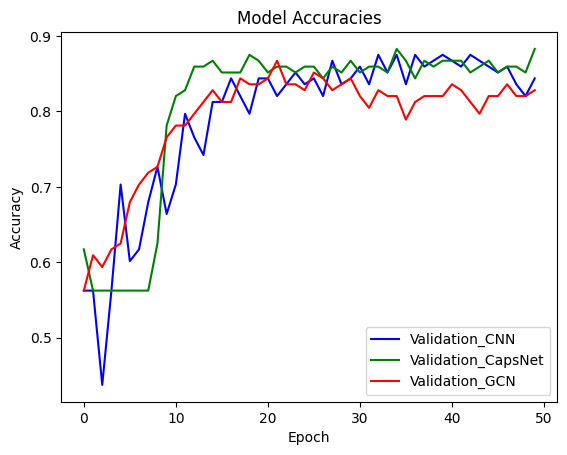

In [ ]:
with strategy.scope():
  # Plotting accuracies
  plt.plot(CNN_history.history['val_accuracy'], label='Validation_CNN', color='blue')
  plt.plot(CapsNet_history.history['val_accuracy'], label='Validation_CapsNet', color='green')
  plt.plot(GCN_history.history['val_accuracy'], label='Validation_GCN', color='red')
  plt.title('Model Accuracies')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()


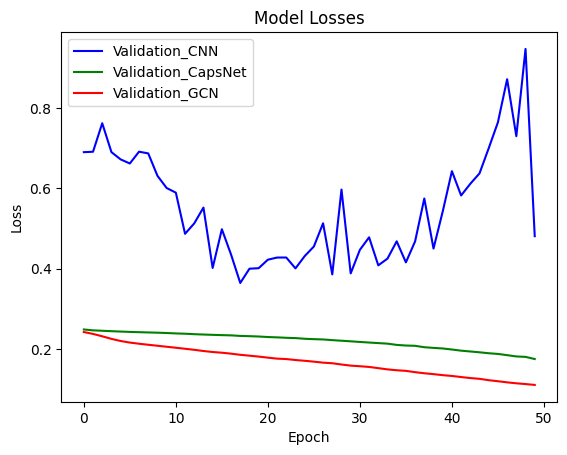

In [ ]:
with strategy.scope():
  # Plotting losses
  plt.plot(CNN_history.history['val_loss'], label='Validation_CNN', color='blue')
  plt.plot(CapsNet_history.history['val_loss'], label='Validation_CapsNet', color='green')
  plt.plot(GCN_history.history['val_loss'], label='Validation_GCN', color='red')
  plt.title('Model Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()


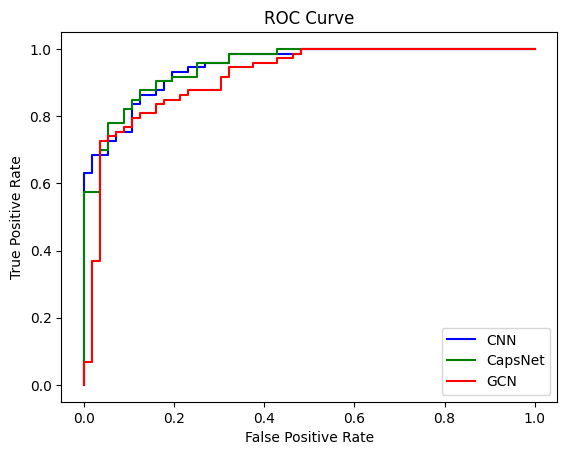

In [ ]:
from sklearn.metrics import roc_curve, auc

# Plotting ROC curve for class 0
fpr, tpr, _ = roc_curve(y_test[:, 0], y_pred_cnn[:, 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='CNN', color='blue')

fpr, tpr, _ = roc_curve(y_test[:, 0], y_pred_capsnet[:, 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='CapsNet', color='green')

fpr, tpr, _ = roc_curve(y_test[:, 0], y_pred_gcn[:, 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='GCN', color='red')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


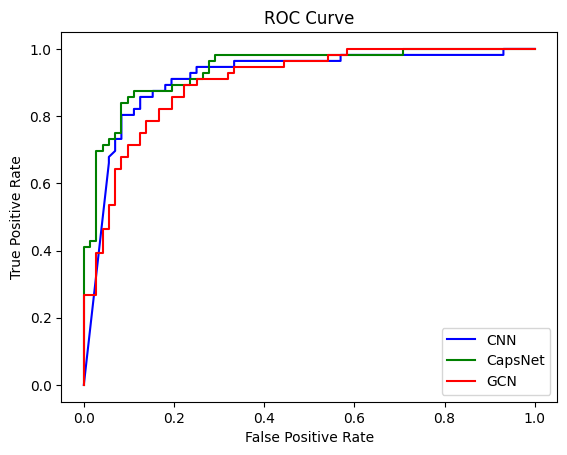

In [ ]:

# Plotting ROC curve for class 0
fpr, tpr, _ = roc_curve(y_val[:, 0], y_val_pred_cnn[:, 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='CNN', color='blue')

fpr, tpr, _ = roc_curve(y_val[:, 0], y_val_pred_capsnet[:, 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='CapsNet', color='green')

fpr, tpr, _ = roc_curve(y_val[:, 0], y_val_pred_gcn[:, 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='GCN', color='red')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
# Print evaluation results
print('#----------------------------------------------------------------------------------------#')
print('EVALUATION OF MODELS (TESTING)')
print('#----------------------------------------------------------------------------------------#')

print('1')
print('CONVOLUTIONAL NEURAL NETWORK:')
print("Accuracy:", cnn_test_acc)
print("Loss:", cnn_test_loss)
print('AUC Score: ', cnn_test_auc_score)
print('')

print('2')
print('***CAPSULE NETWORK***')
print("Accuracy:", capsnet_test_acc)
print("Loss:", capsnet_test_loss)
print('AUC Score: ', capsnet_test_auc_score)
print('')

print('3')
print('***GABOR CAPSULE NETWORK***')
print("Accuracy:", gcn_test_acc)
print("Loss:", gcn_test_loss)
print('AUC Score: ', gcn_test_auc_score)
print('')
print('#----------------------------------------------------------------------------------------#')


#----------------------------------------------------------------------------------------#
EVALUATION OF MODELS (TESTING)
#----------------------------------------------------------------------------------------#
1
CONVOLUTIONAL NEURAL NETWORK:
Accuracy: 0.8604651093482971
Loss: 0.8714019656181335
AUC Score:  0.948018590998043

2
***CAPSULE NETWORK***
Accuracy: 0.8527131676673889
Loss: 0.17693765461444855
AUC Score:  0.9436154598825831

3
***GABOR CAPSULE NETWORK***
Accuracy: 0.8294573426246643
Loss: 0.10849573463201523
AUC Score:  0.9164628180039138

#----------------------------------------------------------------------------------------#


In [ ]:

# Print evaluation results
print('#----------------------------------------------------------------------------------------#')
print('EVALUATION OF MODELS (VALIDATION)')
print('#----------------------------------------------------------------------------------------#')

print('1')
print('CONVOLUTIONAL NEURAL NETWORK:')
print("Accuracy:", cnn_val_acc)
print("Loss:", cnn_val_loss)
print('AUC Score: ', cnn_val_auc_score)
print('')

print('2')
print('***CAPSULE NETWORK***')
print("Accuracy:", capsnet_val_acc)
print("Loss:", capsnet_val_loss)
print('AUC Score: ', capsnet_val_auc_score)
print('')

print('3')
print('***GABOR CAPSULE NETWORK***')
print("Accuracy:", gcn_val_acc)
print("Loss:", gcn_val_loss)
print('AUC Score: ', gcn_val_auc_score)
print('')
print('#----------------------------------------------------------------------------------------#')


#----------------------------------------------------------------------------------------#
EVALUATION OF MODELS (VALIDATION)
#----------------------------------------------------------------------------------------#
1
CONVOLUTIONAL NEURAL NETWORK:
Accuracy: 0.8515625
Loss: 1.9579602479934692
AUC Score:  0.9172867063492064

2
***CAPSULE NETWORK***
Accuracy: 0.875
Loss: 0.17556656897068024
AUC Score:  0.9339037698412699

3
***GABOR CAPSULE NETWORK***
Accuracy: 0.828125
Loss: 0.11014111340045929
AUC Score:  0.9019097222222222

#----------------------------------------------------------------------------------------#


#**Confusion Matrices**

In [ ]:

with strategy.scope():

    # Get true labels from y_test
    y_true_labels = np.argmax(y_test, axis=1)

    # Convert predictions to labels
    y_pred_cnn_labels = np.argmax(y_pred_cnn, axis=1)
    y_pred_capsnet_labels = np.argmax(y_pred_capsnet, axis=1)
    y_pred_gcn_labels = np.argmax(y_pred_gcn, axis=1)

    # Error Analysis
    for i in range(0, len(y_test)):
        true_label = np.argmax(y_test[i])
        cnn_prediction = np.argmax(y_pred_cnn[i])
        capsnet_prediction = np.argmax(y_pred_capsnet[i])
        gcn_prediction = np.argmax(y_pred_gcn[i])

        if true_label != cnn_prediction or true_label != capsnet_prediction or true_label != gcn_prediction:
            print("True Label:", true_label)
            print("CNN Prediction:", cnn_prediction)
            print("CapsNet Prediction:", capsnet_prediction)
            print("GCN Prediction:", gcn_prediction)
            print("---------------------------------")


True Label: 0
CNN Prediction: 0
CapsNet Prediction: 0
GCN Prediction: 1
---------------------------------
True Label: 0
CNN Prediction: 1
CapsNet Prediction: 1
GCN Prediction: 0
---------------------------------
True Label: 0
CNN Prediction: 1
CapsNet Prediction: 1
GCN Prediction: 1
---------------------------------
True Label: 0
CNN Prediction: 0
CapsNet Prediction: 0
GCN Prediction: 1
---------------------------------
True Label: 0
CNN Prediction: 0
CapsNet Prediction: 0
GCN Prediction: 1
---------------------------------
True Label: 0
CNN Prediction: 0
CapsNet Prediction: 1
GCN Prediction: 1
---------------------------------
True Label: 1
CNN Prediction: 0
CapsNet Prediction: 1
GCN Prediction: 1
---------------------------------
True Label: 1
CNN Prediction: 0
CapsNet Prediction: 1
GCN Prediction: 1
---------------------------------
True Label: 0
CNN Prediction: 0
CapsNet Prediction: 1
GCN Prediction: 0
---------------------------------
True Label: 0
CNN Prediction: 1
CapsNet Predic

In [ ]:

# Define a function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

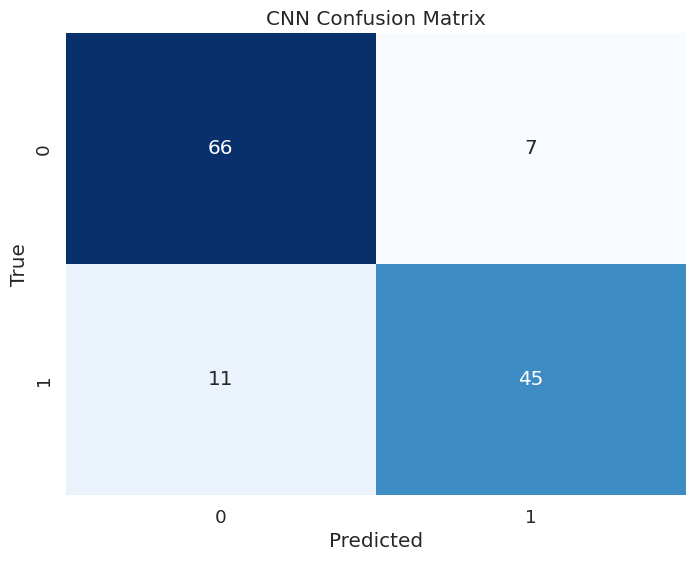

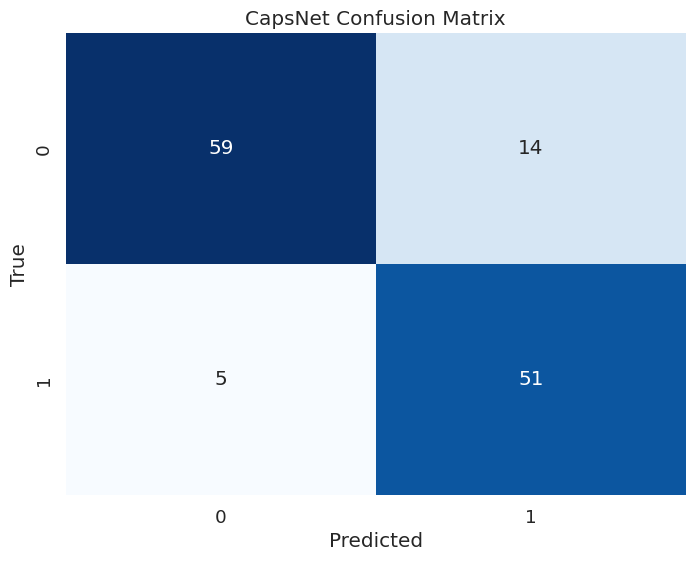

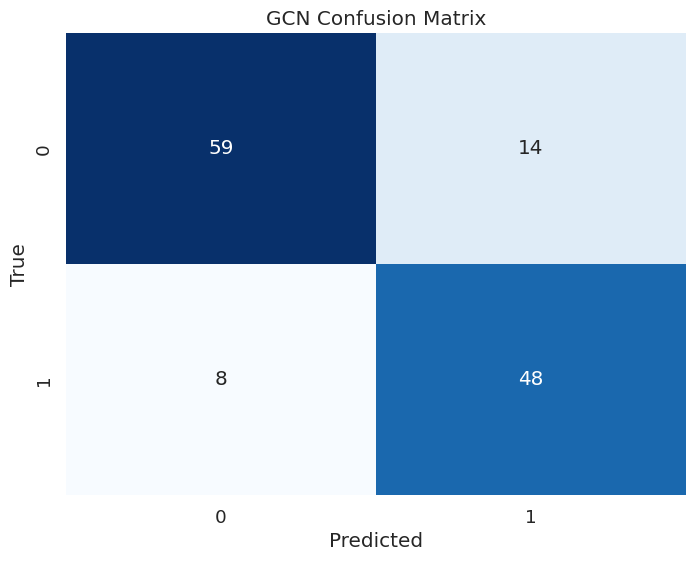

In [ ]:

with strategy.scope():
  # Plot confusion matrices
  classes = np.arange(y_test.shape[1])
  plot_confusion_matrix(y_true_labels, y_pred_cnn_labels, classes, title='CNN Confusion Matrix')
  plot_confusion_matrix(y_true_labels, y_pred_capsnet_labels, classes, title='CapsNet Confusion Matrix')
  plot_confusion_matrix(y_true_labels, y_pred_gcn_labels, classes, title='GCN Confusion Matrix')


#**Testing and Inferencing**

1/1 [==============================] - 0s 68ms/step


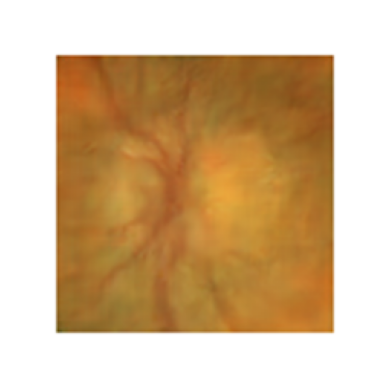

Image: g0.png
CNN Model Classification: Glaucoma
CapsNet Model Classification: Glaucoma
GCN Model Classification: Glaucoma
1/1 [==============================] - 0s 77ms/step


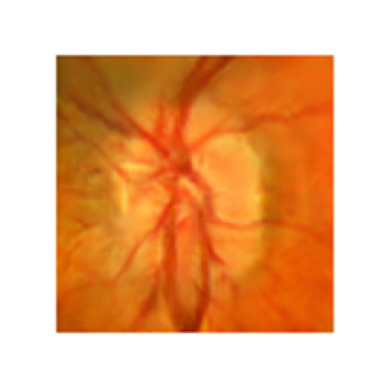

Image: n0.png
CNN Model Classification: Normal
CapsNet Model Classification: Glaucoma
GCN Model Classification: Normal


In [ ]:
# Directory containing the images for inference
images_directory = '/content/drive/MyDrive/Colab Notebooks/Projects/Final(Undergraduate)/ACRIMA_inference'

# Function to load and preprocess an image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((X_train.shape[1], X_train.shape[2]))
    image = np.array(image) / 255.0  # Normalize the image
    return image

# Iterate through all image files in the directory
for filename in os.listdir(images_directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(images_directory, filename)
        test_image = preprocess_image(image_path)

        with strategy.scope():
            # CNN model classification
            cnn_prediction = cnn_model.predict(np.expand_dims(test_image, axis=0))
            cnn_prediction_label = np.argmax(cnn_prediction)
            cnn_prediction_name = class_names[cnn_prediction_label]

            # CapsNet model classification
            capsnet_prediction = CapsNet_model.predict(np.expand_dims(test_image, axis=0))
            capsnet_prediction_label = np.argmax(capsnet_prediction)
            capsnet_prediction_name = class_names[capsnet_prediction_label]

            # GCN model classification
            gcn_prediction = GCN_model.predict(np.expand_dims(test_image, axis=0))
            gcn_prediction_label = np.argmax(gcn_prediction)
            gcn_prediction_name = class_names[gcn_prediction_label]

        # Display the image
        plt.imshow(test_image)
        plt.axis('off')
        plt.show()

        # Print classifications
        print("Image:", filename)
        print("CNN Model Classification:", cnn_prediction_name)
        print("CapsNet Model Classification:", capsnet_prediction_name)
        print("GCN Model Classification:", gcn_prediction_name)


# **Saving and Converting best model**

In [ ]:


with strategy.scope():
    # Specify the path to save the best model
    save_path = '/content/drive/MyDrive/Colab Notebooks/Projects/Final(Undergraduate)/New/savedModels/model.h5'

    # Determine the best model based on a chosen metric (e.g., accuracy and loss)
    best_model_name = None
    best_accuracy = 0.0
    best_loss = float('inf')

    # Check if the CNN model has the best metric
    if cnn_test_acc > best_accuracy and cnn_test_loss < best_loss:
        best_accuracy = cnn_test_acc
        best_loss = cnn_test_loss
        best_model_name = 'CNN model'
        save_model(cnn_model, save_path)  # Save the best CNN model

    # Check if the CapsNet model has the best metric
    if capsnet_test_acc > best_accuracy and capsnet_test_loss < best_loss:
        best_accuracy = capsnet_test_acc
        best_loss = capsnet_test_loss
        best_model_name = 'Capsnet model'
        save_model(CapsNet_model, save_path)  # Save the best CapsNet model

    # Check if the GCN model has the best metric
    if gcn_test_acc > best_accuracy and gcn_test_loss < best_loss:
        best_accuracy = gcn_test_acc
        best_loss = gcn_test_loss
        best_model_name = 'Gabor CapsNet model'
        save_model(GCN_model, save_path)  # Save the best GCN model

    # Define the path for the labels file
    labels_file_path = '/content/drive/MyDrive/Colab Notebooks/Projects/Final(Undergraduate)/New/tflite/labels.txt'

    # Save the labels and class names as a .txt file
    with open(labels_file_path, 'w') as f:
        for class_name, label_idx in train_generator.class_indices.items():
            f.write(class_name + '(' + str(label_idx) + ')' + '\n')

    print('Labels and class names saved as .txt:', labels_file_path)

# Print the details of the best model
print('Best Model:')
print('Accuracy:', best_accuracy)
print('Loss:', best_loss)
print('Model Name:', best_model_name)


Labels and class names saved as .txt: /content/drive/MyDrive/Colab Notebooks/Projects/Final(Undergraduate)/New/tflite/labels.txt
Best Model:
Accuracy: 0.8604651093482971
Loss: 0.8714019656181335
Model Name: CNN model


In [ ]:

# Load the saved model without compiling it
saved_model_path = '/content/drive/MyDrive/Colab Notebooks/Projects/Final(Undergraduate)/New/savedModels/model.h5'

# Define the custom objects dictionary for loading custom layers
custom_objects = {'Class_Capsule': Class_Capsule, 'margin_loss': margin_loss, 'squash': squash}

# Load the saved model with custom layers and loss function
model = tf.keras.models.load_model(saved_model_path, custom_objects=custom_objects, compile=False)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
tflite_model_path = '/content/drive/MyDrive/Colab Notebooks/Projects/Final(Undergraduate)/New/tflite/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print('Model converted and saved as TensorFlow Lite:', tflite_model_path)


Model converted and saved as TensorFlow Lite: /content/drive/MyDrive/Colab Notebooks/Projects/Final(Undergraduate)/New/tflite/model.tflite
